# План семинара

1. Сравниваем PCA, SVD, ALS на примере случайной матрички
2. Знакомимся с датасетом музыки
3. Смотрим на похожести item2item в музыке

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
A = np.random.randn(8, 5)

# PCA

In [9]:
def center_mass(A):
    return A.mean(0)
def covariance(A):
    Am = center_mass(A)
    return (A - Am).T @ (A - Am)

In [10]:
assert covariance(A).shape == (A.shape[1], A.shape[1])
assert center_mass(A).shape == (A.shape[1],)
assert np.allclose(covariance(A), covariance(A).T)

In [11]:
def eig_values(Q):
    return np.linalg.eigh(Q)[0]
def eig_vectors(Q):
    return np.linalg.eigh(Q)[1]

In [12]:
Q = covariance(A)
D, V = eig_values(covariance(A)), eig_vectors(covariance(A))
assert D.shape == (A.shape[1],)
assert V.shape == (A.shape[1], A.shape[1])
assert np.allclose(np.sort(D), D)
assert np.allclose(V.T.dot(V), np.eye(A.shape[1]))
assert np.allclose(V.dot(V.T), np.eye(A.shape[1]))
assert np.allclose(np.trace(covariance(A)), D.sum())
assert np.allclose(V.dot(np.diag(D)).dot(V.T), Q)

Формула для pca: $A=U S V^T + {\rm center\space mass}$

In [17]:
def pca_decomposition(A, k):
    # your code here
    Q = covariance(A)
    D = eig_values(Q)
    V = eig_vectors(Q)
    MA = center_mass(A)
    U = (A - MA) @ V @ np.diag(1/np.sqrt(D))

    l = len(D) - k
    S = np.diag(np.sqrt(D[l:]))
    V = V[:, l:]
    U = U[:, l:]
    return U, S, V, MA

def pca_recover(U, S, V, MA):
    return U @ S @ V.T + MA

In [18]:
k = 2
U, S, V, MA = pca_decomposition(A, k)
assert pca_recover(U, S, V, MA).shape == A.shape
assert U.shape == (A.shape[0], k)
assert S.shape == (k, k)
assert V.shape == (A.shape[1], k)
assert MA.shape == (A.shape[1],)
assert np.allclose(S, np.diag(S.diagonal()))
assert np.allclose(np.sort(S.diagonal()), S.diagonal())
assert np.allclose(U.T.dot(U), np.eye(k))
assert np.allclose(V.T.dot(V), np.eye(k))
assert not np.allclose(V.dot(V.T), np.eye(V.shape[0]))
assert not np.allclose(U.dot(U.T), np.eye(U.shape[0]))
assert np.allclose(pca_recover(*pca_decomposition(A, A.shape[1])), A)

In [19]:
frobenius_norms = []
for k in range(0, 6):
    U, S, V, MA = pca_decomposition(A, k)
    AA = pca_recover(U, S, V, MA)
    frobenius_norms.append(np.sum((A-AA)**2))

print(*["{:.2f}".format(x) for x in frobenius_norms])
assert np.allclose(frobenius_norms[::-1], [0] + list(np.cumsum(eig_values(covariance(A)))))

45.40 31.27 19.69 10.83 3.13 0.00


In [20]:
D

array([ 3.12631945,  7.70259922,  8.8631589 , 11.57783885, 14.13057733])

# SVD

Формула для svd: $A=U S V^T$

In [24]:
def svd_decomposition(A, k):
    # your code here
    Q = A.T @ A
    D = eig_values(Q)
    V = eig_vectors(Q)
    U = A @ V @ np.diag(1 / np.sqrt(D))

    l = len(D) - k
    S = np.diag(np.sqrt(D[l:]))
    V = V[:, l:]
    U = U[:, l:]
    return U, S, V

def svd_recover(U, S, V):
    return U @ S @ V.T

In [25]:
k = 2
U, S, V = svd_decomposition(A, k)
assert svd_recover(U, S, V).shape == A.shape
assert U.shape == (A.shape[0], k)
assert S.shape == (k, k)
assert V.shape == (A.shape[1], k)
assert np.allclose(S, np.diag(S.diagonal()))
assert np.allclose(np.sort(S.diagonal()), S.diagonal())
assert np.allclose(U.T.dot(U), np.eye(k))
assert np.allclose(V.T.dot(V), np.eye(k))
assert not np.allclose(V.dot(V.T), np.eye(V.shape[0]))
assert not np.allclose(U.dot(U.T), np.eye(U.shape[0]))
assert np.allclose(svd_recover(*svd_decomposition(A, A.shape[1])), A)

In [26]:
frobenius_norms = []
for k in range(0, 6):
    U, S, V = svd_decomposition(A, k)
    AA = svd_recover(U, S, V)
    frobenius_norms.append(np.sum((A-AA)**2))

print(*["{:.2f}".format(x) for x in frobenius_norms])
assert np.allclose(frobenius_norms[::-1], [0] + list(np.cumsum(eig_values(A.T.dot(A)))))

49.92 34.13 20.64 11.44 3.40 0.00


# ALS

In [27]:
k = 2
lam = 1e-4

In [28]:
def calc_oposite_vectors(Y, A):
    B = Y.T.dot(Y) + lam * np.eye(k)
    R = A.dot(Y)
446    return np.linalg.inv(B).dot(R.T).T

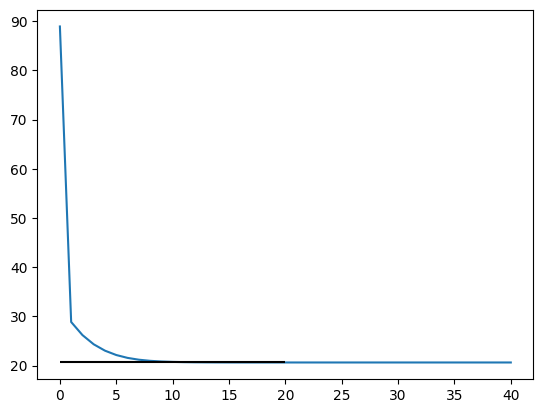

In [29]:
X, Y = np.random.randn(A.shape[0], k), np.random.randn(A.shape[1], k)
frobenius_norms = [np.sum((A - X.dot(Y.T))**2)]
for i in range(20):
    X = calc_oposite_vectors(Y, A)
    frobenius_norms.append(np.sum((A - X @ Y.T) ** 2))
    Y = calc_oposite_vectors(X, A.T)
    frobenius_norms.append(np.sum((A - X @ Y.T) ** 2))
plt.plot(frobenius_norms)
plt.hlines(np.cumsum(eig_values(A.T.dot(A)))[A.shape[1]-k-1], 0, 20, color='black')

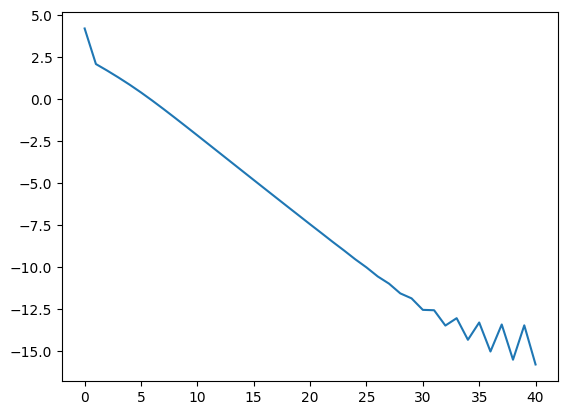

In [30]:
plt.plot(np.log(frobenius_norms-np.cumsum(eig_values(A.T.dot(A)))[A.shape[1]-k-1]))

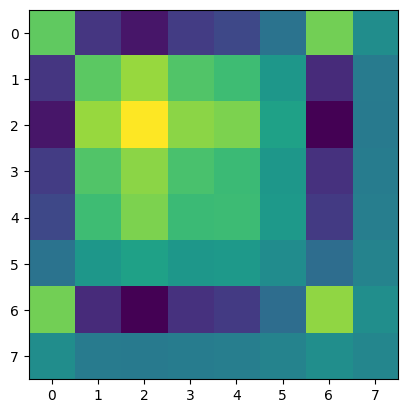

In [31]:
plt.imshow(X.dot(X.T))

In [32]:
X.T.dot(X)

array([[14.85488876, 20.68075714],
       [20.68075714, 32.30370517]])

In [33]:
AA_svd = svd_recover(*svd_decomposition(A, k))
AA_als = X.dot(Y.T)
assert np.allclose(AA_svd, AA_als, rtol=1e-3, atol=1e-3)

# Разбираемся с датасетом музыки

In [34]:
import os, zipfile
from tqdm.notebook import tqdm, tnrange
import scipy.sparse as sp
import pandas as pd

In [22]:
base_name = "yt___home_music_recom_burlada_recsys_2022_02_19_"
for fname in tqdm([n for n in os.listdir(".") if base_name in n and n.endswith(".zip")]):
    extract_name = fname.replace(".zip", "")
    if os.path.exists(extract_name): continue
    with zipfile.ZipFile(fname) as f:
        f.extract(f.filelist[0])

  0%|          | 0/3 [00:00<?, ?it/s]

In [23]:
all_names = pd.read_json("yt___home_music_recom_burlada_recsys_2022_02_19_public_all_names", lines=True)
track_links = pd.read_json("yt___home_music_recom_burlada_recsys_2022_02_19_public_tracks_links", lines=True)
dataset = pd.read_json("yt___home_music_recom_burlada_recsys_2022_02_19_public_data_train", lines=True)

In [24]:
all_names.type.value_counts()

track     1000000
album      658724
artist     153581
genre         166
Name: type, dtype: int64

In [25]:
all_names[all_names.id==5540395]

,type,id,name
766531,artist,5540395,FLESH


In [26]:
track_links

,track_id,albums,artists,genres
0,26,"[3, 2490753]",[16],"[11, 21]"
1,38,"[3, 2490753]",[16],"[11, 21]"
2,135,"[12, 214, 2490809]",[84],[11]
3,136,"[12, 214, 2490809]",[84],[11]
4,138,"[12, 214, 322, 72275, 72292, 91199, 213505, 24...",[84],[11]
...,...,...,...,...
999995,101478482,[21399811],[5540395],"[3, 75]"
999996,101490148,[21403052],[9078726],"[11, 20]"
999997,101493057,[21403883],[11865715],"[44, 75]"
999998,101495927,[21404975],[4462686],"[3, 75]"


In [27]:
dataset

,user_id,track_ids
0,0,"[99262, 589498, 590262, 590303, 590692, 590803..."
1,1,"[24417, 108208, 108209, 592642, 628687, 733449..."
2,2,"[264937, 672689, 4321285, 5335351, 5658525, 58..."
3,3,"[6006252, 21642261, 21642265, 24692821, 259952..."
4,4,"[966, 4094, 9760, 9769, 18392, 19042, 21184, 2..."
...,...,...
1373216,1374578,"[24692821, 29544272, 29904955, 33236014, 33311..."
1373217,1374579,"[54994, 106259, 240171, 245392, 340459, 560468..."
1373218,1374580,"[18860, 33273, 33627, 43115, 43119, 43127, 456..."
1373219,1374581,"[1062, 37615, 40193, 65011, 69400, 117391, 366..."


In [28]:
total_interactions_count = dataset.track_ids.map(len).sum()
user_coo, item_coo = np.zeros(total_interactions_count, dtype=np.int32), np.zeros(total_interactions_count, dtype=np.int32)
pos = 0
for u, tracks in enumerate(tqdm(dataset.track_ids)):
    user_coo[pos:pos+len(tracks)] = u
    item_coo[pos:pos+len(tracks)] = tracks
    pos += len(tracks)
shape = (max(user_coo) + 1, max(item_coo) + 1)
user_item_matrix = sp.coo_matrix((np.ones(len(user_coo)), (user_coo, item_coo)), shape=shape)
user_item_matrix = user_item_matrix.tocsr()
sp.save_npz("data_train.npz", user_item_matrix)
# Cleanup memory. Later you need just data_train.npz
del user_coo
del item_coo
del dataset

  0%|          | 0/1373221 [00:00<?, ?it/s]

In [29]:
item_weights = np.array(user_item_matrix.tocsc().sum(0))[0]
top_to_bottom_order = np.argsort(-item_weights)
item_mapping = np.empty(top_to_bottom_order.shape, dtype=int)
item_mapping[top_to_bottom_order] = np.arange(len(top_to_bottom_order))
total_item_count = (item_weights > 0).sum()
total_user_count = user_item_matrix.shape[0]

def build_dataset(user_item_matrix, item_pct, user_pct):
    user_count, item_count = int(total_user_count * user_pct), int(total_item_count * item_pct)
    item_ids = top_to_bottom_order[:item_count]
    user_ids = np.random.choice(np.arange(user_item_matrix.shape[0]), size=user_count, replace=False)
    train = user_item_matrix[user_ids]
    train = train[:, item_ids]
    return train

In [30]:
small_dataset = build_dataset(user_item_matrix, 0.05, 0.05)

In [31]:
from implicit.nearest_neighbours import ItemItemRecommender

In [32]:
recommender = ItemItemRecommender()

In [33]:
recommender.fit(small_dataset)

  0%|          | 0/50000 [00:00<?, ?it/s]

In [34]:
similar_items = [top_to_bottom_order[k] for k in recommender.similar_items(item_mapping[54302022])[0]]

In [35]:
track_names = all_names[all_names.type=="track"].set_index("id").name.to_dict()
artist_names = all_names[all_names.type=="artist"].set_index("id").name.to_dict()
track_artists = track_links.set_index("track_id").artists.to_dict()
track_artists_names = {track_id:",".join([artist_names[a] for a in artists]) for track_id, artists in track_artists.items()}

In [36]:
pd.DataFrame([{"artist":track_artists_names[track_id], "track": track_names[track_id], "id": track_id} for track_id in similar_items])

,artist,track,id
0,Lindsey Stirling,Underground,54302022
1,Lindsey Stirling,Roundtable Rival,17530540
2,Lindsey Stirling,The Arena,29732355
3,"Tommee Profitt,Fleurie,Mellen Gi",In The End,51241318
4,Evanescence,Bring Me To Life,328683
5,Linkin Park,Numb,178529
6,Lindsey Stirling,Artemis,57043164
7,Imagine Dragons,Believer,33311009
8,Pain,Shut Your Mouth,27032843
9,Nirvana,Smells Like Teen Spirit,53404
